In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'
isic_groundTruth_path = './../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256
IMG_CHANNELS = 4

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)


In [5]:
## Splitting up the dataset for training, validation, and testing

full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [6]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH])
    
    label = tf.round(label / 255.0)
    label = tf.cast(label, tf.float32)
    return label

def decode_label_with_onehot(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH])
    
    one_hot_map = []

    for clr in [0, 255]:
        class_map = tf.equal(label, clr)
        class_map = tf.reduce_all(class_map,axis=-1)
        one_hot_map.append(class_map)
    
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    # label = decode_label_with_onehot(label)
    
    return image, label   

In [7]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)
processed_test_ds = test_ds.map(process_data)

Image shape: b'./../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0013055.jpg'
Label: b'./../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0013055_segmentation.png'

Image shape: (192, 256, 3)
Label: (192, 256, 1)
1


(-0.5, 255.5, 191.5, -0.5)

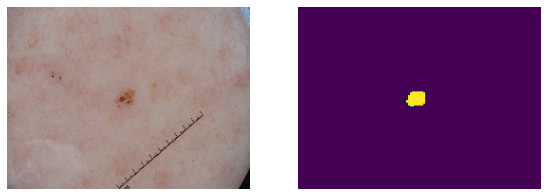

In [8]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()

## Getting the input and output size
input_size = (0, 0, 0)
output_class_num = 0
for image, label in processed_train_ds.take(1):
    input_size = image.numpy().shape
    output_class_num = label.numpy().shape[2]
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy().shape)
plt.figure(figsize=(20, 10))

print(output_class_num)

# print(label)
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 4, 2)
if (output_class_num > 1):
    plt.imshow(tf.argmax(label.numpy(), axis=2))
else:
    plt.imshow(label.numpy())
plt.axis('off')

In [9]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def display(image, ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    colors = ['black', 'green', 'red']
    for i in range(num):
        plt.subplot(4, 3, 3*i+1)
        plt.imshow(image[i])
        title = plt.title('The actual image')
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+2)
        if (output_class_num > 1):
            plt.imshow(tf.argmax(ground_truth[i], axis=2))
        else:
            plt.imshow(ground_truth[i])
        title = plt.title('Ground truth image segmentation')
        plt.setp(title, color=colors[1])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+3)
        if (output_class_num > 1):
            plt.imshow(tf.argmax(prediction[i], axis=2))
        else:
            plt.imshow(prediction[i] > 0.5)
        title = plt.title('Prediction image segmentation')
        plt.setp(title, color=colors[2])
        plt.axis('off')

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()

    
def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(num)))
    prediction = model.predict(image_test_batch)
    display(image_test_batch, label_test_batch, prediction, num)

    
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

In [10]:
from model import *

## Use this one for the original unet model
# model = unet(output_class_num, input_size)

## Use this one for the improved unet model
model = improved_unet(output_class_num, input_size)

print("Loss Function: dice similarity coefficient")
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy', dice_coef])

print()
model.summary()

Activation function: sigmoid
Loss Function: dice similarity coefficient

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 192, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 16) 0           instance_normalization[0][0]     
_____________________

DICE SIMILARITY FOR INPUT 0: 0.23075322806835175
DICE SIMILARITY FOR INPUT 1: 0.939256489276886
DICE SIMILARITY FOR INPUT 2: 0.9315441846847534


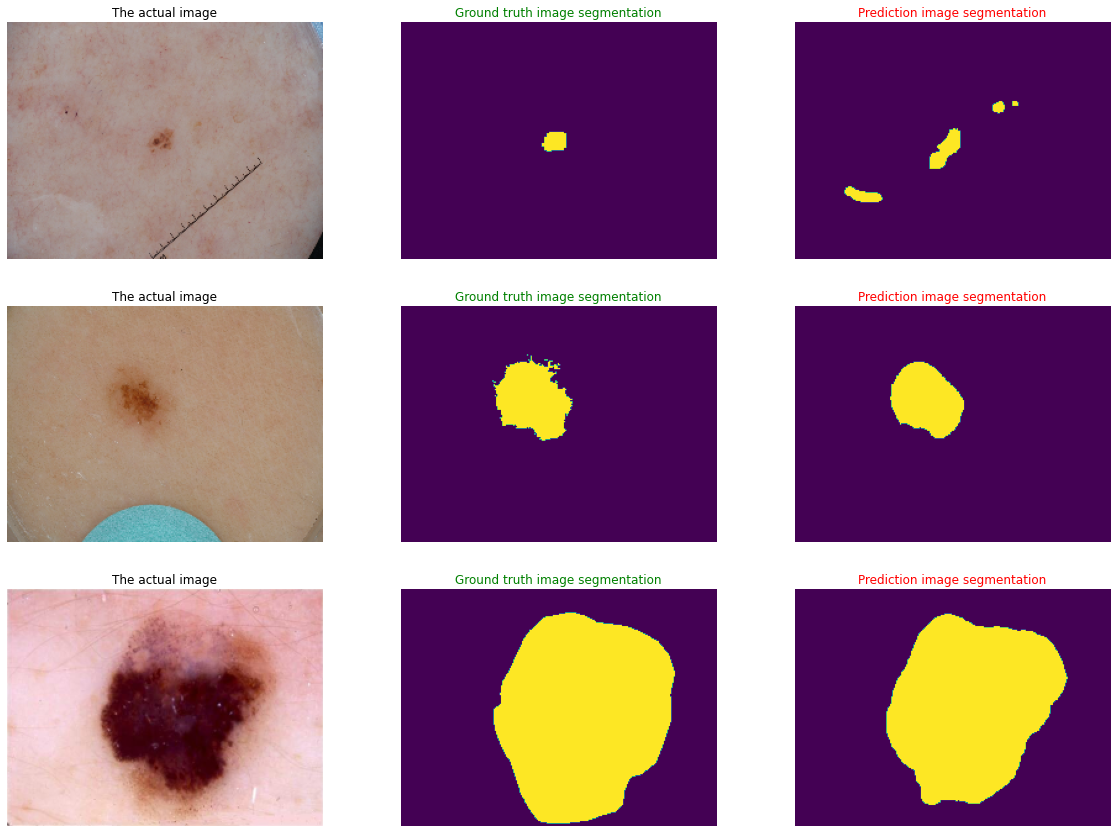

57/57 [==============================] - 285s 5s/step - loss: 0.0912 - accuracy: 0.9508 - dice_coef: 0.9089 - val_loss: 0.1554 - val_accuracy: 0.9165 - val_dice_coef: 0.8446


In [11]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=10, callbacks=[DisplayCallback()])

In [12]:
results = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=1)
print(results)

13/13 [==============================] - 19s 1s/step - loss: 0.1571 - accuracy: 0.9227 - dice_coef: 0.8429
[0.15709634469105646, 0.92270577, 0.8429037]


In [13]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(test_size)))
predictions = model.predict(image_test_batch)

print(predictions.shape)
# plt.imshow(predictions[2])

(389, 192, 256, 1)


In [14]:
bad_dsc = 0
total_dsc = 0
length = predictions.shape[0]
min_dsc = 0.8
print("DSC BELOW {}:".format(min_dsc))
for i in range(length):
    dsc = dice_coef(label_test_batch[i], predictions[i])
    if dsc < min_dsc:
        bad_dsc += 1
        print("  Index {}, dsc is {}".format(i, dsc))
    total_dsc += dsc

print()
print("There are {} bad dsc (< 0.8) out of {}".format(bad_dsc, length))
print("There are {} good dsc (>= 0.8) out of {}".format((length-bad_dsc), length))
print("Average dsc: ", total_dsc/length)

DSC BELOW 0.8:
  Index 0, dsc is 0.23075281083583832
  Index 12, dsc is 0.5293687582015991
  Index 17, dsc is 0.5856708288192749
  Index 18, dsc is 0.6219353675842285
  Index 22, dsc is 0.7864057421684265
  Index 27, dsc is 0.7628942728042603
  Index 30, dsc is 0.765146791934967
  Index 44, dsc is 0.43131035566329956
  Index 52, dsc is 0.5518419742584229
  Index 53, dsc is 0.6445496082305908
  Index 57, dsc is 0.2931716740131378
  Index 62, dsc is 0.058518990874290466
  Index 64, dsc is 0.7171816229820251
  Index 65, dsc is 0.767135739326477
  Index 68, dsc is 0.5137906670570374
  Index 71, dsc is 0.3262580633163452
  Index 72, dsc is 0.7356348633766174
  Index 74, dsc is 0.7341758608818054
  Index 75, dsc is 0.6823045015335083
  Index 82, dsc is 0.7320579290390015
  Index 90, dsc is 0.7602559924125671
  Index 95, dsc is 0.6710982322692871
  Index 100, dsc is 0.20676910877227783
  Index 108, dsc is 0.7769539952278137
  Index 110, dsc is 0.6445015668869019
  Index 117, dsc is 0.62874454

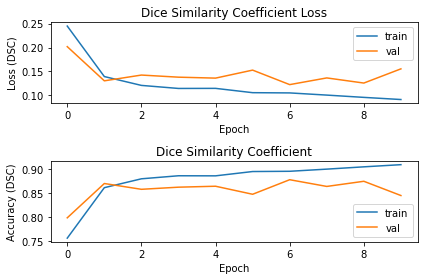

In [15]:
plt.subplot(211)
plt.title('Dice Similarity Coefficient Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (DSC)")

# plot accuracy during training
plt.subplot(212)
plt.title('Dice Similarity Coefficient')
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (DSC)")

plt.tight_layout()
plt.show()